##**AML competition:**

**match the images in a query set with the images in a much larger set called gallery.**

**ResNet50 versions:**

this code has two parts: in the first part we check how the pre-trained model works, we extract the features and try to match images from the query to the gallery images. 
After this initial exploration, in the second and most important part, we fit the model, adding to it some layers, and produce a dictionary of matching images.

**FIRST PART**

Import the necessary libraries.

In [ ]:
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm, tqdm_notebook
import os
import cv2
import random
import time
import math
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

Use the colab GPU for faster execution of the code.

In [ ]:
#must put the notebook setting on GPU first
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Connect colab to google drive, where the dataset with all the images is saved.

In [ ]:
import sys 
from google.colab import drive 
import glob

path = "/content/drive" 
drive.mount(path, force_remount=True)  
data_path = "drive/MyDrive/AML_Challenge/dataset" 

myfiles = glob.glob(os.path.join(data_path, '*')) 
print(myfiles)

Mounted at /content/drive
['drive/MyDrive/AML_Challenge/dataset_senza_aug/training', 'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation', 'drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints', 'drive/MyDrive/AML_Challenge/dataset_senza_aug/test']


Define class Dataset and get training, query and gallery paths.

In [ ]:
class Dataset(object):
    def __init__(self, data_path):
        self.data_path = data_path
        assert os.path.exists(self.data_path), 'Insert a valid path!'

        # get class list
        self.data_classes = os.listdir(self.data_path)

        # init mapping dict
        self.data_mapping = {}

        # populate mapping dict
        for c, c_name in enumerate(self.data_classes):
            temp_path = os.path.join(self.data_path, c_name)
            temp_images = os.listdir(temp_path)

            for i in temp_images:
                img_tmp = os.path.join(temp_path, i)

                if img_tmp.endswith('.jpg'):
                    if c_name == 'distractor':
                        self.data_mapping[img_tmp] = -1
                    else:
                        self.data_mapping[img_tmp] = int(c_name)

        print('Loaded {:d} from {:s} images'.format(len(self.data_mapping.keys()),
                                                    self.data_path))

    def get_data_paths(self):
        # returns a list of images paths and related classes
        images = []
        classes = []
        for img_path in self.data_mapping.keys():
            if img_path.endswith('.jpg'):
                images.append(img_path)
                classes.append(self.data_mapping[img_path])
        return images, np.array(classes)


    def num_classes(self):
        # returns number of classes of the dataset
        return len(self.data_classes)




# dataset folder has inside two folders: training and validation
# the validation one contains the query and gallery folders

validation_path = os.path.join(data_path, 'validation')
gallery_path = os.path.join(validation_path, 'gallery')
query_path = os.path.join(validation_path, 'query')
training_path = os.path.join(data_path, "training") 

training_dataset = Dataset(data_path = training_path)
gallery_dataset = Dataset(data_path=gallery_path)
query_dataset = Dataset(data_path=query_path)

# get training data and classes
training_paths, training_classes = training_dataset.get_data_paths()

# get validation gallery and query data
gallery_paths, gallery_classes = gallery_dataset.get_data_paths()
query_paths, query_classes = query_dataset.get_data_paths()


Loaded 697 from drive/MyDrive/AML_Challenge/dataset_senza_aug/training images
Loaded 534 from drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery images
Loaded 70 from drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/query images


Define the model to use. We tested several model, both by writing layer by layer ourselves and by taking the pre-trained model from the keras library (https://keras.io/api/applications/). We found that VGG16 and ResNet50 work equally well in our case and we chose to use the second one.

In [ ]:
#ResNet50 is a convolutional Neural Network with 50 layers, pretrained on more than a million images from ImageNet. It requires as input images of dimension 224x224.

model=ResNet50(weights='imagenet',
                         include_top=False, #does not include a fully-connected layer at the top of the network
                         input_shape=(224, 224, 3),
                        pooling='max') #global max pooling

Using keras, we firstly defined the ImageDataGenerator function, which specify all the modifications we want to make to our training images in order to add some noises and make it more challenging to associate query and gallery images.

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False, #set input mean to zero if True
    samplewise_center=True, #set each sample mean to zero
    featurewise_std_normalization=False, #divide inputs by sd of the dataset
    samplewise_std_normalization=True, #divide each input by its sd 
    rotation_range=20, #degree range for random rotation
    width_shift_range=0.3, #range as a fraction of total width within which to randomly translate pictures vertically 
    height_shift_range=0.3, #ranges as a fraction of total height within which to randomly translate pictures horizontally
    brightness_range=None,
    zoom_range=0.3,
    fill_mode="nearest",
    rescale=None, #all data are multiplied by specified value if given
    preprocessing_function=None, #preprocessing function to execute after the image is resized and augmented (input must be numpy tensor with rank 3)
    data_format=None 
)


The following code produces augmented images by applying the modifications defined above to the training images. The augmented images are then saved in the folder corresponding to their belonging class.

**NOTE**: this function has been already ran on our dataset, thus all the pictures have been augmented and the augmented images have been saved on the folder corresponding to their class. This function does not have to be ran again on our dataset since it would generate a lot of new images, augmenting also already augmented images and making the execution of the code much slower.

In [ ]:
def augmented_img(training_paths):

      input_shape = (224, 224, 3)
      prep_img=[]
      img_in_folder=os.listdir(training_paths) #list of images in the folder considered
      for el in img_in_folder: 
        path=os.path.join(training_paths, el)
        img = image.load_img(path, target_size=(input_shape[0], input_shape[1])) #read single image

        img_array = image.img_to_array(img) #convert images in 3D arrays automatically 
        expanded_img_array = np.expand_dims(img_array, axis=0) #img_array has shape (None, 3) now; the first dimension need to be expanded (tensorflow)
        preprocessed_img = preprocess_input(expanded_img_array) #images are converted from RGB to BGR (tensorflow)
        prep_img.append(preprocessed_img)

      #for each image given as input, five augmented images are generated:
      for img in prep_img:
        i = 0
        for batch in datagen.flow(prep_img, 
                                  batch_size=1, 
                                  save_to_dir=training_paths,  
                                  save_prefix='aug',
                                  save_format='jpg'):    
          i += 1    
          if i > 5:  #5 image -> generates 5 augmented images     
            break

list_classes = set(training_classes)
list_classes.remove(-1)
list_classes.add('distractor')
for el in list_classes:
    folder = os.path.join(training_path, str(el))
    augmented_img(folder)

For convenience, let's load again our training path, now containing both the original data and the augmented ones.

In [ ]:
training_path = os.path.join(data_path, "training") 
training_dataset = Dataset(data_path = training_path)

training_paths, training_classes = training_dataset.get_data_paths()

Loaded 697 from drive/MyDrive/AML_Challenge/dataset_senza_aug/training images


The following function extracts the features from the images after pre-processing them. The images are firstly converted into arrays, which are then processed in order to be reduced into a tensor of one dimension. The features are then normalized and a list of all normalized features is returned. The features extraction strictly depends on the model chosen.

**Note**: each keras pre-trained neural network requires a specific kind of preprocessing. The one used here is specific for ResNet50, as it is possible to notice in the first cell, when we imported the preprocess_input function from tf.keras.applications.resnet50

In [ ]:
def extract_features(training_paths, model):
    input_shape = (224, 224, 3) #standard shape required by the keras model 
    nf=[]
    for n in range(len(training_paths)):
      img = image.load_img(training_paths[n],
                          target_size=(input_shape[0], input_shape[1]))
      img_array = image.img_to_array(img) #convert images in 3D arrays authomatically 
      expanded_img_array = np.expand_dims(img_array, axis=0) #img_array has shape (None, 3) now; the first dimension need to be expanded using this command
      preprocessed_img = preprocess_input(expanded_img_array) #images are converted from RGB to BGR and then each channel is zero-centered with respect to the ImageNet dataset
      features = model.predict(preprocessed_img) #extract features from the images 
      flattened_features = features.flatten() #collapse array into one dimension
      normalized_features = flattened_features / norm(flattened_features) #normalize
      nf.append(normalized_features)
    return nf

Now we can use the function defined above to extract the features from our query and gallery sets.

In [ ]:
#normalized query features
query_features = extract_features(query_paths, model)

#normalized gallery features
gallery_features = extract_features(gallery_paths, model)


The match_img function has the purpose of computing the euclidean distance between the query image given as input and the gallery images. The function then returns the top-5 results, namely the images representing, with the highest accuracy, the same subject as the one in the given query image.

In [ ]:
def match_img(query_img_feat):
  distance = np.linalg.norm(gallery_features - query_img_feat, axis=1) #vectorial distance
  acc = np.argsort(distance)[:5]  #top 5 results
  scores = [(distance[a], gallery_paths[a]) for a in acc] #rank the results
  return (acc, scores)

Now we can use our model.
We pass the features of a randomly chosen query image to the match_img function to check whether the computed association with the gallery images is correct.

In [ ]:
match_img(query_features[20])

(array([471, 467, 470, 473, 468]),
 [(0.6510603,
   'drive/MyDrive/AML_Challenge/dataset/validation/gallery/6/ec50k_00060011.jpg'),
  (0.6893744,
   'drive/MyDrive/AML_Challenge/dataset/validation/gallery/6/ec50k_00060013.jpg'),
  (0.7030033,
   'drive/MyDrive/AML_Challenge/dataset/validation/gallery/6/ec50k_00060012.jpg'),
  (0.70909005,
   'drive/MyDrive/AML_Challenge/dataset/validation/gallery/6/ec50k_00060006.jpg'),
  (0.7129083,
   'drive/MyDrive/AML_Challenge/dataset/validation/gallery/6/ec50k_00060009.jpg')])

Below we visualized the chosen query image to check whether it corresponds to the images belonging to class 6 in the gallery set, as the results above suggested. We found that the association is correct.

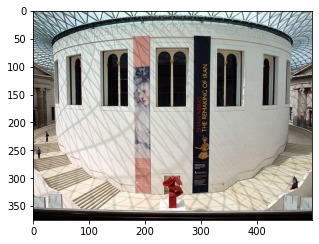

In [ ]:
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize = (5,5))
img = cv2.imread(query_paths[20])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

If compared with the results that we obtained before augmenting the data, the distances are way lower in some cases, as in the example below.
However, the matching is always correct.

In [ ]:
match_img(query_features[14])

(array([412, 409, 411, 408, 410]),
 [(0.4264267,
   'drive/MyDrive/AML_Challenge/dataset/validation/gallery/4/ec50k_00040007.jpg'),
  (0.4623438,
   'drive/MyDrive/AML_Challenge/dataset/validation/gallery/4/ec50k_00040008.jpg'),
  (0.50523967,
   'drive/MyDrive/AML_Challenge/dataset/validation/gallery/4/ec50k_00040006.jpg'),
  (0.5422174,
   'drive/MyDrive/AML_Challenge/dataset/validation/gallery/4/ec50k_00040009.jpg'),
  (0.6256152,
   'drive/MyDrive/AML_Challenge/dataset/validation/gallery/4/ec50k_00040014.jpg')])

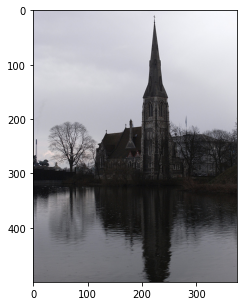

In [ ]:
import matplotlib.pyplot as plt
import cv2
plt.figure(figsize = (5,5))
img = cv2.imread(query_paths[14])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

#The chosen query image does belong to class 4.

**SECOND PART**

In [ ]:
import sys 
from google.colab import drive 
import glob

path = "/content/drive" 
drive.mount(path, force_remount=True)  
data_path = "drive/MyDrive/AML_Challenge/dataset_senza_aug" 

myfiles = glob.glob(os.path.join(data_path, '*')) 
print(myfiles)

Mounted at /content/drive
['drive/MyDrive/AML_Challenge/dataset_senza_aug/training', 'drive/MyDrive/AML_Challenge/dataset_senza_aug/validation', 'drive/MyDrive/AML_Challenge/dataset_senza_aug/siamese_checkpoints', 'drive/MyDrive/AML_Challenge/dataset_senza_aug/test']


In [ ]:
#here we are using the class Dataset defined above, in the first part

validation_path = os.path.join(data_path, 'validation')
gallery_path = os.path.join(validation_path, 'gallery')
query_path = os.path.join(validation_path, 'query')
training_path = os.path.join(data_path, "training") 

training_dataset = Dataset(data_path = training_path)
gallery_dataset = Dataset(data_path=gallery_path)
query_dataset = Dataset(data_path=query_path)

# get training data and classes
training_paths, training_classes = training_dataset.get_data_paths()

# get validation gallery and query data
gallery_paths, gallery_classes = gallery_dataset.get_data_paths()
query_paths, query_classes = query_dataset.get_data_paths()

Loaded 697 from drive/MyDrive/AML_Challenge/dataset_senza_aug/training images
Loaded 534 from drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/gallery images
Loaded 70 from drive/MyDrive/AML_Challenge/dataset_senza_aug/validation/query images


Taking advantage of ImageDataGenerator, we add some noises to the images and we pre-process them using the specific pre-processing function of the keras-defined ResNet50.

In [ ]:
def generators(preprocessing): 
    '''
    Create the training and validation datasets for 
    a given image shape.
    '''
    datagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0,
    )


    train_dataset = datagen.flow_from_directory(
        training_path,
        target_size = (224,224), 
        batch_size = 16,
        subset = 'training', 
    )

    return train_dataset

In [ ]:
train_dataset = generators(preprocessing=preprocess_input)

Found 697 images belonging to 22 classes.


Now we create the model, starting with ResNet50 and adding to it some layes. Finally, we fit it on the training dataset.

In [ ]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in resnet_model.layers:
    layer.trainable = False
x = Flatten()(resnet_model.output)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
preds = Dense(22, activation='softmax')(x)
full_model = Model(inputs=resnet_model.input, outputs=preds)
full_model.summary()

In [ ]:
full_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
history = full_model.fit_generator(
    train_dataset, 
    epochs=15)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
44/44 [==============================] - 8s 111ms/step - loss: 0.0044 - acc: 0.9943
Epoch 2/15
44/44 [==============================] - 5s 111ms/step - loss: 0.0099 - acc: 0.9914
Epoch 3/15
44/44 [==============================] - 5s 112ms/step - loss: 0.0371 - acc: 0.9828
Epoch 4/15
44/44 [==============================] - 5s 112ms/step - loss: 0.0157 - acc: 0.9928
Epoch 5/15
44/44 [==============================] - 5s 113ms/step - loss: 0.0102 - acc: 0.9928
Epoch 6/15
44/44 [==============================] - 5s 113ms/step - loss: 0.0056 - acc: 0.9971
Epoch 7/15
44/44 [==============================] - 5s 113ms/step - loss: 0.0065 - acc: 0.9986
Epoch 8/15
44/44 [==============================] - 5s 112ms/step - loss: 0.0095 - acc: 0.9943
Epoch 9/15
44/44 [==============================] - 5s 111ms/step - loss: 0.0088 - acc: 0.9928
Epoch 10/15
44/44 [==============================] - 5s 113ms/step - loss: 0.0052 - acc: 0.9986
Epoch 11/15
44/44 [==============================

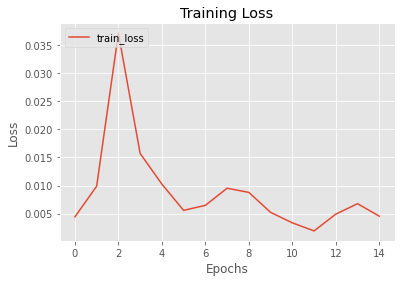

In [ ]:
import matplotlib.pyplot as plt

def plot_training(hist, plot_path):
	'''
  This function the training and validation loss over the number of epochs and saves the training history.
  '''
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(hist.history['loss'], label = 'train_loss')
	plt.title('Training Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend(loc = 'upper left')
	plt.savefig(plot_path)
 
plot_training(history, data_path) 


For convenience and clarity, we copy the previously defined functions for extracting the features and for the matching below.

In [ ]:
def extract_features(training_paths, model):
    input_shape = (224, 224, 3) #standard shape required by the keras model 
    nf=[]
    for n in range(len(training_paths)):
      img = image.load_img(training_paths[n],
                          target_size=(input_shape[0], input_shape[1]))
      img_array = image.img_to_array(img) #convert images in 3D arrays authomatically 
      expanded_img_array = np.expand_dims(img_array, axis=0) #img_array has shape (None, 3) now; the first dimension need to be expanded using this command
      preprocessed_img = preprocess_input(expanded_img_array) #images are converted from RGB to BGR and then each channel is zero-centered with respect to the ImageNet dataset
      features = model.predict(preprocessed_img) #extract features from the images 
      flattened_features = features.flatten() #collapse array into one dimension
      normalized_features = flattened_features / norm(flattened_features) #normalize
      nf.append(normalized_features)
    return nf


def match_img(query_img_feat):
  distance = np.linalg.norm(gallery_features - query_img_feat, axis=1) #vectorial distance
  acc = np.argsort(distance)[:5]  #top 5 results
  scores = [(distance[a], gallery_paths[a]) for a in acc] #rank the results
  return (acc, scores)
  

In [ ]:
query_features = extract_features(query_paths, model)
gallery_features = extract_features(gallery_paths, model)

In [ ]:
match_img(query_features[1])

In [ ]:
from pprint import pprint
results = {}
for img in query_paths: 
  results[os.path.basename(img)] = []
for i, feat in enumerate(query_features) : 
  acc, scores = match_img(feat)
  results[os.path.basename(query_paths[i])].extend([os.path.basename(sc[1]) for sc in scores])
pprint(results)

{'ec50k_00020001.jpg': ['ec50k_00020013.jpg',
                        'ec50k_00020008.jpg',
                        'ec50k_00020006.jpg',
                        'ec50k_00020007.jpg',
                        'ec50k_00020012.jpg'],
 'ec50k_00020002.jpg': ['ec50k_00020013.jpg',
                        'ec50k_00020008.jpg',
                        'ec50k_00020006.jpg',
                        'ec50k_00020007.jpg',
                        'ec50k_00020009.jpg'],
 'ec50k_00020003.jpg': ['ec50k_00020013.jpg',
                        'ec50k_00020008.jpg',
                        'ec50k_00020006.jpg',
                        'ec50k_00020012.jpg',
                        'ec50k_00020007.jpg'],
 'ec50k_00020004.jpg': ['ec50k_00020009.jpg',
                        'ec50k_00020006.jpg',
                        'ec50k_00020010.jpg',
                        'ec50k_00020008.jpg',
                        'ec50k_00020013.jpg'],
 'ec50k_00020005.jpg': ['ec50k_00020013.jpg',
                        'ec50k

**CHALLENGE DAY:**

Testing the model on the unlabeled query and gallery images from the test set:

In [ ]:
test_path= os.path.join(data_path, "test")

gallery_path = os.path.join(test_path, 'gallery')
query_path = os.path.join(test_path, 'query')

def imag_load(path) : 
  temp_images = os.listdir(path)
  lista = []
  for i in temp_images:
    img_tmp = os.path.join(path, i)
    lista.append(img_tmp)
  return lista

gallery = imag_load(gallery_path)
query = imag_load(query_path)

In [ ]:
def match_img(one_query_img_feat, gallery_features, gallery_paths):
  distance = np.linalg.norm(gallery_features - one_query_img_feat, axis=1) #vectorial distance
  acc = np.argsort(distance)[:5]  #top 5 results
  scores = [(distance[a], gallery_paths[a]) for a in acc] #rank the results
  return (acc, scores)

In [ ]:
gallery_features = extract_features(gallery, model)
query_features = extract_features(query, model)

In [ ]:
match_img(query_features[1], gallery_features, gallery)

(array([ 22, 397, 174,  59, 259]),
 [(0.68415505,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/test/gallery/14kx20j.jpg'),
  (0.68735135,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/test/gallery/xpcii72.jpg'),
  (0.70169276,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/test/gallery/dsqnx6p.jpg'),
  (0.70892996,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/test/gallery/50c6lzi.jpg'),
  (0.71632504,
   'drive/MyDrive/AML_Challenge/dataset_senza_aug/test/gallery/psc4i5p.jpg')])

In [ ]:
from pprint import pprint
results = {}
for img in query: 
  #results[img] = []
  results[os.path.basename(img)] = []
for i, feat in enumerate(query_features) : 
  acc, scores = match_img(feat, gallery_features, gallery)
  #pprint(scores)
  #results[query_paths[i]].extend([sc[1] for sc in scores])
  results[os.path.basename(query[i])].extend([os.path.basename(sc[1]) for sc in scores])
pprint(results)

{'3fpri33.jpg': ['90e01s6.jpg',
                 'tqibo20.jpg',
                 '50c6lzi.jpg',
                 'h1myait.jpg',
                 'p49x44a.jpg'],
 '4uufzmh.jpg': ['yp9lv9j.jpg',
                 'u2vc46s.jpg',
                 'xpcii72.jpg',
                 'lv2zrrb.jpg',
                 'qh067xt.jpg'],
 '5qcsiay.jpg': ['vur3qkh.jpg',
                 '1y0cjdn.jpg',
                 'xpcii72.jpg',
                 '7lx9gn6.jpg',
                 'z9gysj1.jpg'],
 '8d6bnrk.jpg': ['cftkf1t.jpg',
                 'yp9lv9j.jpg',
                 'ky0a2wr.jpg',
                 '5ke31ly.jpg',
                 'xpcii72.jpg'],
 'e7hrc0v.jpg': ['szwz6h0.jpg',
                 'mq275v4.jpg',
                 'kx0hd4t.jpg',
                 'ee5occc.jpg',
                 '4i7uy3a.jpg'],
 'hx5h2mt.jpg': ['dlwucps.jpg',
                 'hqmr9vf.jpg',
                 'xvhz7aw.jpg',
                 '6h1rkk2.jpg',
                 'mluaaxx.jpg'],
 'j4aovhl.jpg': ['pkwu9eg.jpg',
  

In [ ]:
import requests
import json


url = "http://ec2-18-191-24-254.us-east-2.compute.amazonaws.com/competition/"

In [ ]:
mydata = dict()
mydata['groupname'] = "lesdesesperadas"


res = results
mydata["images"] = res
pprint(mydata)

In [ ]:
def submit(results, url):
    res = json.dumps(results)
    response = requests.post(url, res)
    result = json.loads(response.text)
    print(f"accuracy is {result['results']}")

submit(mydata, url)

accuracy is {'top1': 0.5333333333333333, 'top3': 0.7333333333333333, 'top10': 0.8666666666666667}
